In [1]:
#Instalamos algunas librerias, podemos usar el requirements.txt también.
!pip install anthropic pandas matplotlib pillow


In [2]:
#Importamos algunos directorios:
import os

os.makedirs("data/el_martillo", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


In [3]:
#Importamos la pagina del periodico que utilizaremos:
from google.colab import files

uploaded = files.upload()  # eligimos página escaneada
filename = list(uploaded.keys())[0]

# movemos el archivo a data/
import shutil
shutil.move(filename, f"data/el_martillo/page_01.png")

IMG_PATH = "data/el_martillo/page_01.png"
IMG_PATH


Saving page_01.png to page_01.png


'data/el_martillo/page_01.png'

In [ ]:
#Ponemos la clave de Claude API:
API_KEY = ""


In [5]:
#Importamos algunas librerias:
import base64
import json
import requests

endpoint = "https://api.anthropic.com/v1/messages"

# Cargamos imagen como base64
with open(IMG_PATH, "rb") as f:
    img_b64 = base64.b64encode(f.read()).decode()

# Prompt que fuerza JSON estrictamente válido
prompt = """
Eres un modelo OCR especializado en periódicos antiguos peruanos (1900–1920).

Tarea:
1. Lee la página completa.
2. Divide el contenido en BLOQUES.
3. Para cada bloque devuelve:
   - headline (si existe)
   - section (noticias, avisos, anuncios, opinión, crónica, etc.)
   - type (article, advertisement, other)
   - text (texto completo del bloque)
4. Devuelve SALIDA JSON válida.

Formato JSON:
{
  "blocks": [
    {
      "headline": "...",
      "section": "...",
      "type": "...",
      "text": "..."
    }
  ]
}
"""
payload = {
    "model": "claude-sonnet-4-20250514",   # modelo vision que sí tienes
    "max_tokens": 8000,
    "messages": [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/png",
                        "data": img_b64
                    }
                }
            ]
        }
    ]
}

response = requests.post(
    endpoint,
    headers={
        "x-api-key": API_KEY,
        "anthropic-version": "2023-06-01"
    },
    json=payload
)

ocr_json = response.json()

In [6]:
#Verificamos el contenido del archivo json generado:
print(ocr_json)

{'model': 'claude-sonnet-4-20250514', 'id': 'msg_017WzecJLyC7SHKMHhDXUkg1', 'type': 'message', 'role': 'assistant', 'content': [{'type': 'text', 'text': '```json\n{\n  "blocks": [\n    {\n      "headline": "DESDE ETEN",\n      "section": "noticias",\n      "type": "article",\n      "text": "DESDE ETEN\\n\\nEsta siempre noble, si tanto atormentada.\\n\\nAunque ayer se jugaron dos partidos de foot-ball entre equipos de distinguidos jóvenes, que con tanta nitidez se desarrollaron y para ello evitaron telégrafos de la región.\\n\\nLa primera de estas competiciones se realizó en dos plazas, quedado los interesantes visitantes casi en tablas sin grandes modificaciones o alteraciones que sean reñidas de comicos del fútbol.\\n\\nHay otros atentos aquí esperando su vez cuando menos no se esperaba. De cuyos nombres tenemos noticias del distinguido señor Aurelio que empezó el team del famoso conjunto, así desde años ha venido viendo poco papeles de medida, ante los más severos críticos que no aún

In [7]:

# Extraemos solo el texto del modelo:

# Claude responde en ocr_json["content"][0]["text"]
raw_text = ocr_json["content"][0]["text"]

# limpiamos posibles bloqueos de markdown
cleaned = (
    raw_text.replace("```json", "")
            .replace("```", "")
            .strip()
)

# parseamos JSON:
try:
    parsed = json.loads(cleaned)
except Exception as e:
    print("❌ ERROR PARSEANDO JSON")
    print(cleaned)
    raise e

# guardamos resultado:

with open("outputs/ocr_blocks.json", "w", encoding="utf-8") as f:
    json.dump(parsed, f, ensure_ascii=False, indent=2)

print("✔ OCR completado y guardado en outputs/ocr_blocks.json")


✔ OCR completado y guardado en outputs/ocr_blocks.json


In [8]:
import pandas as pd
import json

# Cargamos JSON limpio:
with open("outputs/ocr_blocks.json", "r", encoding="utf-8") as f:
    data = json.load(f)

rows = []

DATE = "1906-02-08"
ISSUE = "1609"

# Normalizamos bloques:

for block in data["blocks"]:
    headline = block.get("title", "").strip()
    section = block.get("section", "").strip()
    tipo = block.get("type", "").strip()
    texto = block.get("text", "").replace("\n", " ").strip()

    rows.append({
        "date": DATE,
        "issue_number": ISSUE,
        "headline": headline,
        "section": section,
        "type": tipo,
        "text_excerpt": texto
    })

# Creamos dataframe:
df = pd.DataFrame(rows)

# Guardamos CSV con separador ; y codificación UTF-8 con BOM:
df.to_csv("outputs/el_martillo_dataset.csv",
          index=False,
          sep="@",             # separador de columnas
          encoding="utf-8-sig") # UTF-8 con BOM para que Excel muestre tildes correctamente

df



,date,issue_number,headline,section,type,text_excerpt
0,1906-02-08,1609,,noticias,article,"DESDE ETEN Esta siempre noble, si tanto atorm..."
1,1906-02-08,1609,,noticias,article,"Cocolazos CUENTO DE LA GUERRA Capítulo 2º, 3..."
2,1906-02-08,1609,,avisos,advertisement,COOPERATIVA WIZARD Arte el Notario Público se...
3,1906-02-08,1609,,avisos,advertisement,"FOTOGRAFÍA ""ARTELIER"" Nº 140 Abierta las Salas..."
4,1906-02-08,1609,,avisos,advertisement,SOMBREROS de la última moda. RAIME ZENLLE Mod...


In [9]:
# Revisamos el contenido de la celda más larga (solo porseacaso):
max_len_index = df["text_excerpt"].str.len().idxmax()
print(df.loc[max_len_index, "text_excerpt"])
print("Longitud de la celda:", len(df.loc[max_len_index, "text_excerpt"]))


COOPERATIVA WIZARD  Arte el Notario Público señor José Alzina Lasierra, el día 30 de octubre actual, la Sociedad Cooperativa de Consumo "Wizard", entre otros de J. S. Christie, Pedro J. Washington, Baltimore, Malitez, y otras más, principalmente los que deseen los siguientes socios de la coopera-tiva:  Luis D. Wolf, del 1º de marzo. Cuello sucursal de estrecha administrador de depósito marítimo cuya extensión tendrá derecho a la dirección por sus cosas derivadas a la distribución de los empleados del aberto central.  La de elenias de cada serie a su vez pone en consideración a los candidatos que en su oferta de sus de la plaza y esperan su nombramiento de los fondos apropiados del gerente social de la casa en la administración de la sociedad.  En la sucursal 6 de la cera El canal y aledaños, por administración de caja de la cooperativa, en Chimbote, se dispone a hacer un servicio abierto para el resto, todas también de fondos de trabajo.  El servicio 3 de la vera El canal donde el trab

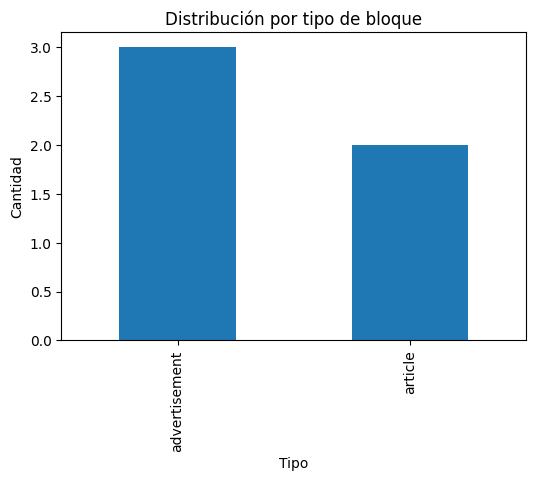

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

type_counts = df["type"].value_counts()

plt.figure(figsize=(6,4))
type_counts.plot(kind="bar")
plt.title("Distribución por tipo de bloque")
plt.xlabel("Tipo")
plt.ylabel("Cantidad")
plt.show()

# Guardamos figura
plt.savefig("outputs/type_counts.png")


In [11]:
#Guardamos los outputs:

from google.colab import files

files.download("outputs/el_martillo_dataset.csv")
files.download("outputs/type_counts.png")
files.download("outputs/ocr_blocks.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>